# Forecast for Energy Mix

## 1.Setup

In [1]:
from IPython.display import clear_output

In [2]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install skforecast
# !pip install scikit-learn==1.2
# !pip install pycaret

clear_output()

In [3]:
# import sklearn
# print(sklearn.__version__)

In [4]:
import openmeteo_requests
import requests_cache
from retry_requests import retry
import time

# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openmeteo_requests
import requests_cache
from retry_requests import retry
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.datasets import fetch_dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# from pycaret.regression import *

# Import libraries
import requests
from datetime import datetime, timedelta, date
import openmeteo_requests
import requests_cache
from retry_requests import retry
import pytz


In [5]:
google_drive_path = "/content/drive/MyDrive/LINC/"

In [6]:
# Backtesting with custom metric
# ==============================================================================
def custom_mape(y_true, y_pred):
    mape = (np.abs(y_pred - y_true) / np.abs(y_true)).map(lambda x: 0 if math.isnan(x) else x)
    mape = mape.map(lambda x: 1 if math.isinf(x) else x)
    return np.mean(mape)

In [7]:
# Backtesting with custom metric
# ==============================================================================
def custom_smape(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))).map(lambda x: 0 if math.isnan(x) else x))

## 2.Get historical weather data

In [8]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [9]:
def get_weather_historical(lati, longi, suffix):

  url = "https://archive-api.open-meteo.com/v1/archive"

  params = {
	  "latitude": lati,
	  "longitude": longi,
	  "start_date": "2023-01-01",
	  "end_date": "2024-05-30",
    "hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "rain", "pressure_msl", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m", "is_day", "sunshine_duration", "shortwave_radiation", "direct_radiation", "diffuse_radiation", "direct_normal_irradiance", "terrestrial_radiation", "shortwave_radiation_instant", "direct_radiation_instant", "diffuse_radiation_instant", "direct_normal_irradiance_instant", "terrestrial_radiation_instant"],
	  "timezone": "Europe/Warsaw"
  }

  responses = openmeteo.weather_api(url, params=params)

  # Process first location. Add a for-loop for multiple locations or weather models
  response = responses[0]

  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
  hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
  hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
  hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
  hourly_rain = hourly.Variables(4).ValuesAsNumpy()
  hourly_pressure_msl = hourly.Variables(5).ValuesAsNumpy()
  hourly_surface_pressure = hourly.Variables(6).ValuesAsNumpy()
  hourly_cloud_cover = hourly.Variables(7).ValuesAsNumpy()
  hourly_cloud_cover_low = hourly.Variables(8).ValuesAsNumpy()
  hourly_cloud_cover_mid = hourly.Variables(9).ValuesAsNumpy()
  hourly_cloud_cover_high = hourly.Variables(10).ValuesAsNumpy()
  hourly_wind_speed_10m = hourly.Variables(11).ValuesAsNumpy()
  hourly_wind_speed_100m = hourly.Variables(12).ValuesAsNumpy()
  hourly_wind_direction_10m = hourly.Variables(13).ValuesAsNumpy()
  hourly_wind_direction_100m = hourly.Variables(14).ValuesAsNumpy()
  hourly_wind_gusts_10m = hourly.Variables(15).ValuesAsNumpy()
  hourly_is_day = hourly.Variables(16).ValuesAsNumpy()
  hourly_sunshine_duration = hourly.Variables(17).ValuesAsNumpy()
  hourly_shortwave_radiation = hourly.Variables(18).ValuesAsNumpy()
  hourly_direct_radiation = hourly.Variables(19).ValuesAsNumpy()
  hourly_diffuse_radiation = hourly.Variables(20).ValuesAsNumpy()
  hourly_direct_normal_irradiance = hourly.Variables(21).ValuesAsNumpy()
  hourly_terrestrial_radiation = hourly.Variables(22).ValuesAsNumpy()
  hourly_shortwave_radiation_instant = hourly.Variables(23).ValuesAsNumpy()
  hourly_direct_radiation_instant = hourly.Variables(24).ValuesAsNumpy()
  hourly_diffuse_radiation_instant = hourly.Variables(25).ValuesAsNumpy()
  hourly_direct_normal_irradiance_instant = hourly.Variables(26).ValuesAsNumpy()
  hourly_terrestrial_radiation_instant = hourly.Variables(27).ValuesAsNumpy()

  hourly_data = {"date": pd.date_range(
	  start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	  end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	  freq = pd.Timedelta(seconds = hourly.Interval()),
	  inclusive = "left"
  )}

  hourly_data["temperature_2m"] = hourly_temperature_2m
  hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
  hourly_data["apparent_temperature"] = hourly_apparent_temperature
  hourly_data["precipitation"] = hourly_precipitation
  hourly_data["rain"] = hourly_rain
  hourly_data["pressure_msl"] = hourly_pressure_msl
  hourly_data["surface_pressure"] = hourly_surface_pressure
  hourly_data["cloud_cover"] = hourly_cloud_cover
  hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
  hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
  hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
  hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
  hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
  hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
  hourly_data["wind_direction_100m"] = hourly_wind_direction_100m
  hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
  hourly_data["is_day"] = hourly_is_day
  hourly_data["sunshine_duration"] = hourly_sunshine_duration
  hourly_data["shortwave_radiation"] = hourly_shortwave_radiation
  hourly_data["direct_radiation"] = hourly_direct_radiation
  hourly_data["diffuse_radiation"] = hourly_diffuse_radiation
  hourly_data["direct_normal_irradiance"] = hourly_direct_normal_irradiance
  hourly_data["terrestrial_radiation"] = hourly_terrestrial_radiation
  hourly_data["shortwave_radiation_instant"] = hourly_shortwave_radiation_instant
  hourly_data["direct_radiation_instant"] = hourly_direct_radiation_instant
  hourly_data["diffuse_radiation_instant"] = hourly_diffuse_radiation_instant
  hourly_data["direct_normal_irradiance_instant"] = hourly_direct_normal_irradiance_instant
  hourly_data["terrestrial_radiation_instant"] = hourly_terrestrial_radiation_instant

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  hourly_dataframe['date'] = hourly_dataframe['date'].dt.tz_convert('Europe/Warsaw')

  # Adding suffix to columns 2 to 4
  for col in hourly_dataframe.columns[1:]:  # Columns 2 to end
    hourly_dataframe.rename(columns={col: col + suffix}, inplace=True)

  return hourly_dataframe
  # hourly_dataframe

In [10]:
# Wind farms
# ------------
# https://www.thewindpower.net/country_zones_en_27_poland.php
df_wind1 = get_weather_historical(53.4658, 15.1823, '_wind1') #Zachodniopomorskie
df_wind2 = get_weather_historical(54.2944, 18.1531, '_wind2') # Pomorskie
df_wind3 = get_weather_historical(52.28, 17.3523, "_wind3") # Wielkopolskie

time.sleep(60)

# PVs
# ----
# https://www.power-technology.com/data-insights/top-five-solar-pv-plants-in-operation-in-poland/
df_pv1 = get_weather_historical(52.0135, 18.63, "_pv1") # Turek Solar PV Park https://www.gem.wiki/Przykona_solar_farm
df_pv2 = get_weather_historical(52.0816, 18.6499, "_pv2") # Brudzew Solar PV Park https://www.gem.wiki/Brudzew_solar_farm
df_pv3 = get_weather_historical(52.6579, 14.882, "_pv3") # Witnica Solar PV Park https://www.gem.wiki/Witnica_solar_farm

time.sleep(60)

# Weather big cities
# ------------------
# https://www.statista.com/statistics/1455315/poland-largest-cities-by-population/
df_t1 = get_weather_historical(52.2297, 21.0122, "_t1") # warsaw
df_t2 = get_weather_historical(50.0647, 19.9450, "_t2") # krakow
df_t3 = get_weather_historical(54.3520, 18.6466, "_t3") # gdansk

df_weather_historical = df_wind1.merge(df_wind2, on='date', how='inner').\
                              merge(df_wind3, on='date', how='inner').\
                              merge(df_pv1, on='date', how='inner').\
                              merge(df_pv2, on='date', how='inner').\
                              merge(df_pv3, on='date', how='inner').\
                              merge(df_t1, on='date', how='inner').\
                              merge(df_t2, on='date', how='inner').\
                              merge(df_t3, on='date', how='inner')
df_weather_historical

,date,temperature_2m_wind1,relative_humidity_2m_wind1,apparent_temperature_wind1,precipitation_wind1,rain_wind1,pressure_msl_wind1,surface_pressure_wind1,cloud_cover_wind1,cloud_cover_low_wind1,...,shortwave_radiation_t3,direct_radiation_t3,diffuse_radiation_t3,direct_normal_irradiance_t3,terrestrial_radiation_t3,shortwave_radiation_instant_t3,direct_radiation_instant_t3,diffuse_radiation_instant_t3,direct_normal_irradiance_instant_t3,terrestrial_radiation_instant_t3
0,2022-12-31 23:00:00+01:00,14.409000,74.378571,9.870138,0.0,0.0,1008.400024,999.818298,100.000000,65.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-01-01 00:00:00+01:00,14.059000,71.860046,9.284261,0.0,0.0,1008.700012,1000.105103,45.900002,13.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2023-01-01 01:00:00+01:00,13.609000,70.571175,9.084556,0.0,0.0,1008.400024,999.794434,73.800003,8.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2023-01-01 02:00:00+01:00,13.959001,66.229645,9.059750,0.0,0.0,1008.900024,1000.300537,100.000000,100.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2023-01-01 03:00:00+01:00,14.759001,60.160999,9.318270,0.0,0.0,1008.799988,1000.225220,100.000000,63.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12379,2024-05-30 19:00:00+02:00,18.959000,69.064247,17.708681,1.6,1.6,1006.200012,997.769775,93.600006,30.0,...,231.0,127.0,104.0,380.322205,444.441284,182.166061,100.151901,82.014153,380.322174,350.485321
12380,2024-05-30 20:00:00+02:00,17.109001,85.233948,17.118692,0.5,0.5,1005.599976,997.121277,31.800001,1.0,...,111.0,52.0,59.0,268.390747,257.864868,71.799675,33.635883,38.163792,268.390747,166.798340
12381,2024-05-30 21:00:00+02:00,16.509001,90.269516,16.833487,0.0,0.0,1005.500000,997.004578,38.700001,0.0,...,29.0,11.0,18.0,111.280914,81.260033,0.000000,0.000000,0.000000,0.000000,0.000000
12382,2024-05-30 22:00:00+02:00,15.909000,89.066025,15.589577,0.0,0.0,1005.500000,996.987122,30.300001,1.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 3.Combing with historical energy mix data

In [11]:
df_EnMix_historical = pd.read_csv(google_drive_path + "EnergyMix_PL_historical_estimated.csv")
df_EnMix_historical = df_EnMix_historical.dropna().reset_index(drop=True)
df_EnMix_historical['timestamp'] = pd.to_datetime(df_EnMix_historical['timestamp'], utc = True).dt.tz_convert('Europe/Warsaw')
df_EnMix_historical

,timestamp,total,wind,oil,gas,coal,biomass,pv,water
0,2023-01-01 01:00:00+01:00,14444.438,5529.188,197.539,1006.358,7523.575,0,0.000,187.778
1,2023-01-01 02:00:00+01:00,13690.800,4250.700,209.640,1068.008,7984.472,0,0.000,177.980
2,2023-01-01 03:00:00+01:00,13440.763,3124.613,229.542,1169.399,8742.479,0,0.000,174.730
3,2023-01-01 04:00:00+01:00,13428.488,3486.663,221.073,1126.254,8419.927,0,0.000,174.570
4,2023-01-01 05:00:00+01:00,13642.538,4257.800,208.401,1061.696,7937.288,0,0.000,177.353
...,...,...,...,...,...,...,...,...,...
12402,2024-05-31 20:00:00+02:00,16607.525,770.913,332.557,1694.207,12665.963,0,927.988,215.898
12403,2024-05-31 21:00:00+02:00,16673.713,966.775,341.910,1741.856,13022.189,0,384.225,216.758
12404,2024-05-31 22:00:00+02:00,16226.913,1327.963,332.145,1692.111,12650.294,0,13.450,210.950
12405,2024-05-31 23:00:00+02:00,14930.163,1568.638,298.033,1518.326,11351.074,0,0.000,194.092


In [12]:
df_model = pd.merge(df_weather_historical, df_EnMix_historical, how='left', left_on='date', right_on='timestamp').drop(columns = ['timestamp'])
df_model[['total', 'wind', 'oil',	'gas', 'coal', 'biomass', 'pv', 'water']] = \
df_model[['total', 'wind', 'oil',	'gas', 'coal', 'biomass', 'pv', 'water']].fillna(method='ffill')
df_model['dow'] = df_model['date'].dt.dayofweek
df_model['mmonth'] = df_model['date'].dt.month
df_model['hhour'] = df_model['date'].dt.hour
df_model = df_model.set_index('date')
df_model = df_model.asfreq('H')
df_model = df_model.sort_index().dropna(how = "any")
df_model

,temperature_2m_wind1,relative_humidity_2m_wind1,apparent_temperature_wind1,precipitation_wind1,rain_wind1,pressure_msl_wind1,surface_pressure_wind1,cloud_cover_wind1,cloud_cover_low_wind1,cloud_cover_mid_wind1,...,wind,oil,gas,coal,biomass,pv,water,dow,mmonth,hhour
date,,,,,,,,,,,,,,,,,,,,,
2023-01-01 01:00:00+01:00,13.609000,70.571175,9.084556,0.0,0.0,1008.400024,999.794434,73.800003,8.0,61.0,...,5529.188,197.539,1006.358,7523.575,0.0,0.000,187.778,6,1,1
2023-01-01 02:00:00+01:00,13.959001,66.229645,9.059750,0.0,0.0,1008.900024,1000.300537,100.000000,100.0,97.0,...,4250.700,209.640,1068.008,7984.472,0.0,0.000,177.980,6,1,2
2023-01-01 03:00:00+01:00,14.759001,60.160999,9.318270,0.0,0.0,1008.799988,1000.225220,100.000000,63.0,100.0,...,3124.613,229.542,1169.399,8742.479,0.0,0.000,174.730,6,1,3
2023-01-01 04:00:00+01:00,15.259001,56.099483,9.681547,0.0,0.0,1009.200012,1000.636658,100.000000,95.0,98.0,...,3486.663,221.073,1126.254,8419.927,0.0,0.000,174.570,6,1,4
2023-01-01 05:00:00+01:00,15.159000,54.737705,9.710276,0.0,0.0,1009.400024,1000.831787,100.000000,18.0,100.0,...,4257.800,208.401,1061.696,7937.288,0.0,0.000,177.353,6,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30 19:00:00+02:00,18.959000,69.064247,17.708681,1.6,1.6,1006.200012,997.769775,93.600006,30.0,61.0,...,2168.975,264.870,1349.376,10087.994,0.0,1924.425,208.048,3,5,19
2024-05-30 20:00:00+02:00,17.109001,85.233948,17.118692,0.5,0.5,1005.599976,997.121277,31.800001,1.0,2.0,...,2167.775,303.928,1548.357,11575.583,0.0,867.900,216.845,3,5,20
2024-05-30 21:00:00+02:00,16.509001,90.269516,16.833487,0.0,0.0,1005.500000,997.004578,38.700001,0.0,16.0,...,1771.088,328.842,1675.282,12524.482,0.0,325.100,218.969,3,5,21


In [13]:
# df_train_1= df_wind_1[df_wind_1.index >= pd.Timestamp('2023-01-01', tz='Europe/Athens')]
df_train = df_model[df_model.index < pd.Timestamp('2024-01-01', tz='Europe/Warsaw')]
df_test = df_model[df_model.index >= pd.Timestamp('2024-01-01', tz='Europe/Warsaw')]

In [14]:
df_train.shape, df_test.shape

((8759, 263), (3623, 263))

## 4.Wind Model

<Axes: >

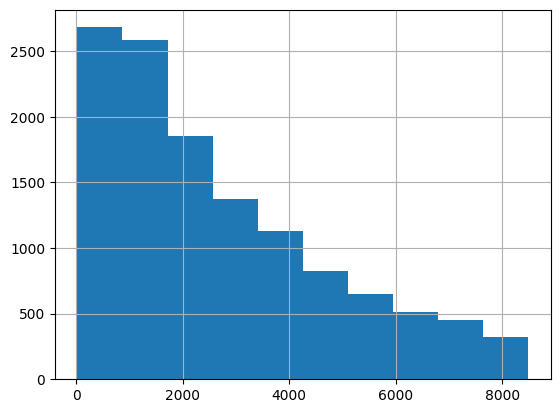

In [ ]:
df_model['wind'].hist()

### 4.1. Recursive multi-step forecasting (with weather inputs from 3 wind farms)

#### 4.2.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1014048.6284790642
RMSE: 1006.9998155307995
MAE: 767.2901649461771
MAPE: 0.33309423985739767
Custom MAPE: 0.33309423985739767
Custom sMAPE: 0.15625638041629655


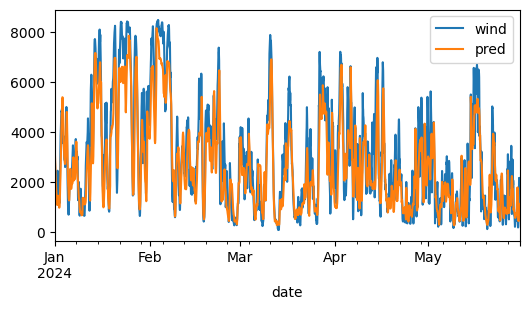

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
df_test[df_test.wind < 100]

,temperature_2m_wind1,relative_humidity_2m_wind1,apparent_temperature_wind1,precipitation_wind1,rain_wind1,pressure_msl_wind1,surface_pressure_wind1,cloud_cover_wind1,cloud_cover_low_wind1,cloud_cover_mid_wind1,...,wind,oil,gas,coal,biomass,pv,water,dow,mmonth,hhour
date,,,,,,,,,,,,,,,,,,,,,
2024-03-13 12:00:00+01:00,9.559000,82.689079,7.321463,0.2,0.2,1016.799988,1007.999023,80.099998,49.0,60.0,...,93.288,392.248,1998.304,14939.406,0.0,2634.938,264.191,2,3,12
2024-03-13 13:00:00+01:00,10.209001,75.703537,7.703632,0.1,0.1,1016.799988,1008.019043,100.000000,98.0,60.0,...,93.050,394.812,2011.366,15037.058,0.0,2831.225,268.265,2,3,13
2024-03-13 15:00:00+01:00,11.459001,60.832466,8.756348,0.0,0.0,1016.299988,1007.561584,99.000000,100.0,15.0,...,90.813,399.664,2036.083,15221.842,0.0,2170.950,262.362,2,3,15
2024-03-13 16:00:00+01:00,11.259001,62.076550,8.701024,0.0,0.0,1016.200012,1007.456360,67.799995,74.0,2.0,...,80.138,420.238,2140.897,16005.442,0.0,1440.413,264.572,2,3,16
2024-03-13 17:00:00+01:00,10.609000,69.982140,8.778045,0.0,0.0,1016.099976,1007.337341,31.500000,35.0,0.0,...,96.088,439.534,2239.199,16740.348,0.0,795.738,267.520,2,3,17


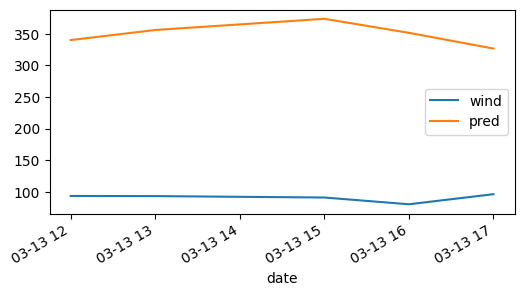

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.wind < 100]['wind'].plot(ax=ax)
predictions[df_test.wind < 100].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
forecaster.fit(
    df_train['wind'],
    exog = df_train[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                     'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                     'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']])
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.986655
1,lag_2,0.003864
2,lag_3,0.002056
25,wind_speed_100m_wind1,0.001165
35,wind_speed_100m_wind3,0.000587
3,lag_4,0.000544
30,wind_speed_100m_wind2,0.000444
24,wind_speed_10m_wind1,0.000418
4,lag_5,0.000252
28,wind_gusts_10m_wind1,0.000247


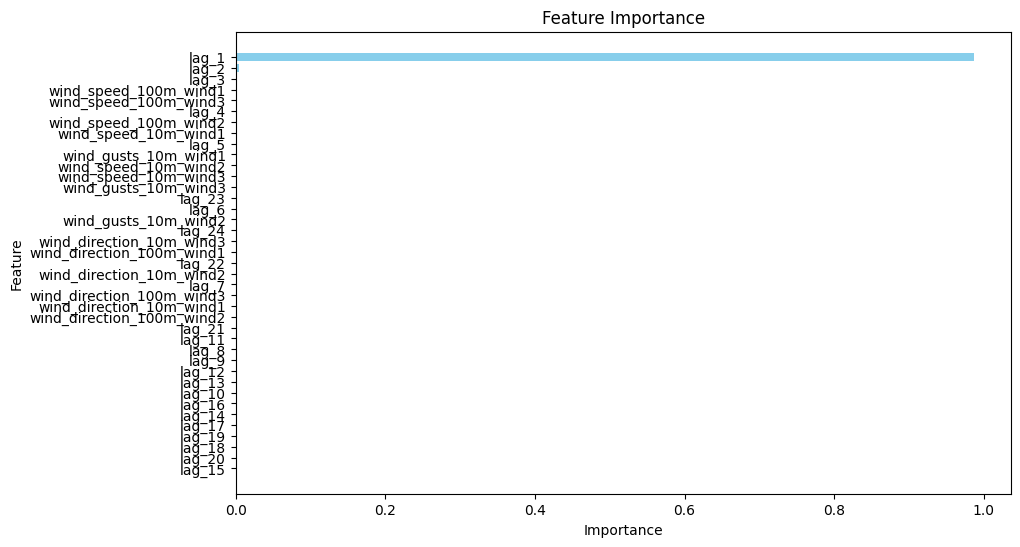

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 4.2.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, n_jobs = -1),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 39
[LightGBM] [Info] Start training from score 2518.594167


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 501615.99056123215
RMSE: 708.2485372813926
MAE: 538.3649549956215
MAPE: 0.23222668272476668
Custom MAPE: 0.23222668272476668
Custom sMAPE: 0.11811450573023208


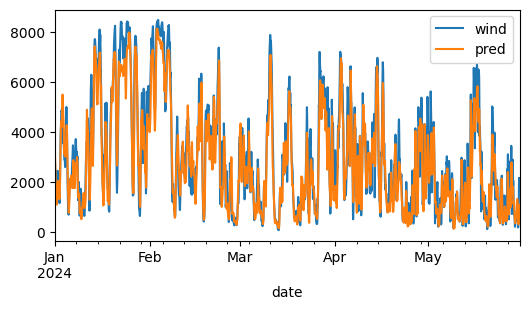

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

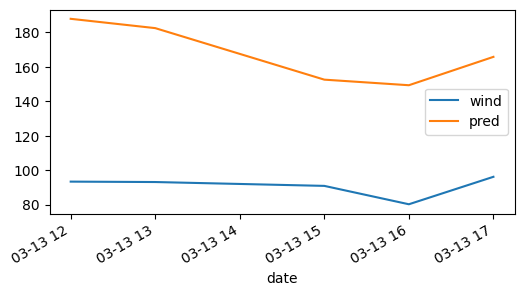

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.wind < 100]['wind'].plot(ax=ax)
predictions[df_test.wind < 100].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
forecaster.fit(
    df_train['wind'],
    exog = df_train[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                     'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                     'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']])
forecaster.get_feature_importances()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9740
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 39
[LightGBM] [Info] Start training from score 2518.594167


,feature,importance
0,lag_1,538
1,lag_2,308
30,wind_speed_100m_wind2,171
25,wind_speed_100m_wind1,168
35,wind_speed_100m_wind3,145
2,lag_3,142
38,wind_gusts_10m_wind3,95
22,lag_23,79
23,lag_24,78
3,lag_4,78


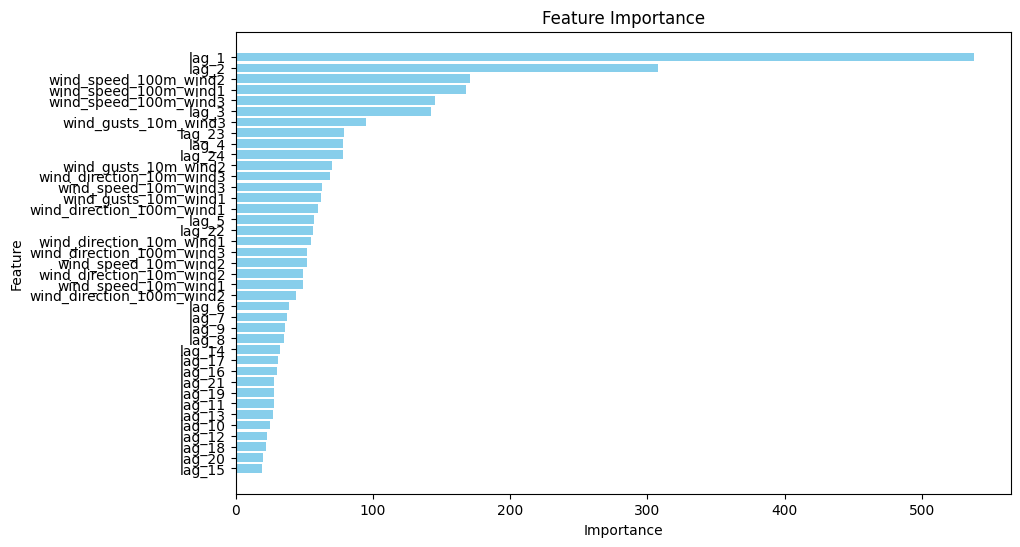

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 4.2.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123, n_jobs = -1),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 548539.0308762916
RMSE: 740.6342085512197
MAE: 559.8275379817519
MAPE: 0.24924425929293845
Custom MAPE: 0.24924425929293845
Custom sMAPE: 0.12659261226229346


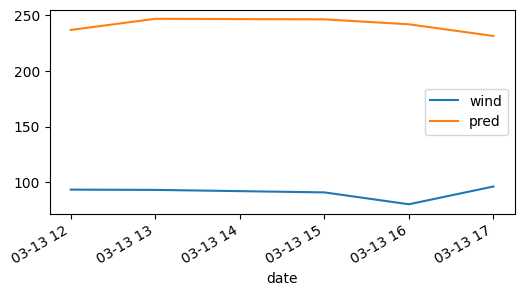

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.wind < 100]['wind'].plot(ax=ax)
predictions[df_test.wind < 100].plot(ax=ax)
ax.legend()
plt.show()

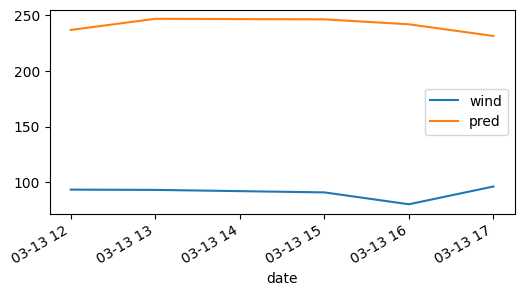

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.wind < 100]['wind'].plot(ax=ax)
predictions[df_test.wind < 100].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
forecaster.fit(
    df_train['wind'],
    exog = df_train[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                     'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                     'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']])
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.954030
25,wind_speed_100m_wind1,0.005378
1,lag_2,0.005337
2,lag_3,0.005001
30,wind_speed_100m_wind2,0.003835
35,wind_speed_100m_wind3,0.003577
22,lag_23,0.001075
36,wind_direction_10m_wind3,0.000960
21,lag_22,0.000954
3,lag_4,0.000883


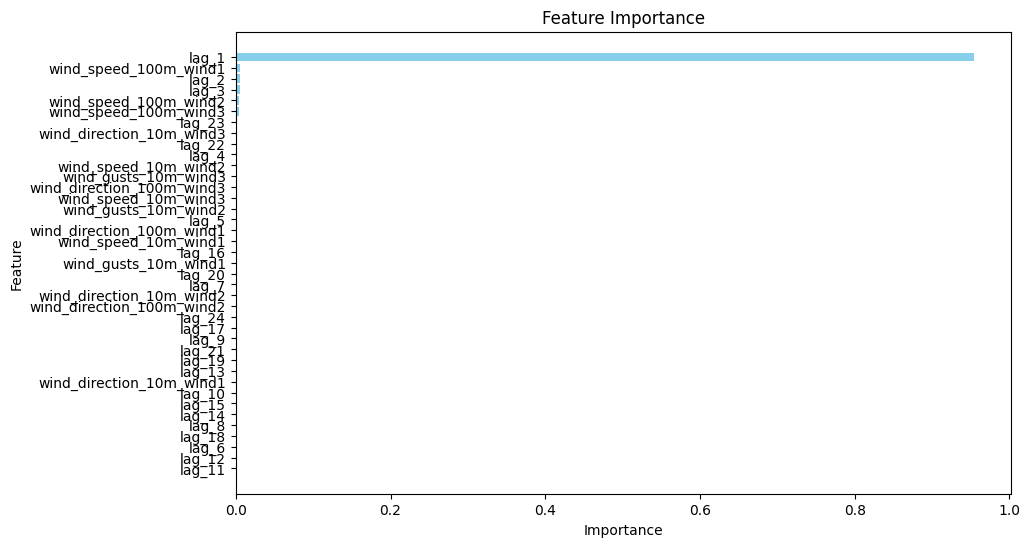

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 4.2.4. Optuna (LightGBM)

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, n_jobs = -1),
                 lags      = 1 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 2, 3]),
        'num_leaves'       : trial.suggest_int('num_leaves', 2, 256),
        'max_depth'        : trial.suggest_int('max_depth', -1, 16),
        'learning_rate'    : trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'n_estimators'     : trial.suggest_int('n_estimators', 50, 1500),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
        'subsample'        : trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq'   : trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],
                          search_space          = search_space,
                          steps                 = 24*3,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          n_trials              = 100,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_total_recursive_optuna_lightGBM.txt"
                      )

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-19 08:31:14,550] Trial 0 finished with value: 488.58613741515103 and parameters: {'lags': 1, 'num_leaves': 142, 'max_depth': 11, 'learning_rate': 0.00492522233779106, 'n_estimators': 1473, 'min_child_samples': 70, 'min_child_weight': 0.2538981330307094, 'subsample': 0.45290576637473545, 'subsample_freq': 3, 'colsample_bytree': 0.7561447366456374, 'reg_alpha': 3.225358230874411e-05, 'reg_lambda': 3.0020863018484457e-08}. Best is trial 0 with value: 488.58613741515103.
[I 2024-07-19 08:31:23,729] Trial 1 finished with value: 474.9080155645633 and parameters: {'lags': 2, 'num_leaves': 46, 'max_depth': 8, 'learning_rate': 0.013406343673102117, 'n_estimators': 970, 'min_child_samples': 86, 'min_child_weight': 4.19060401068387, 'subsample': 0.6499211596098246, 'subsample_freq': 7, 'colsample_bytree': 0.39066302246786044, 'reg_alpha': 7.839876925917444e-06, 'reg_lambda': 6.70047894794746e-07}. Best is trial 1 with value: 474.9080155645633.
[I 2024-07-19 08:31:30,927] Trial 2 finish

In [ ]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 1, 'num_leaves': 112, 'max_depth': 6, 'learning_rate': 0.022526024805622016, 'n_estimators': 1493, 'min_child_samples': 84, 'min_child_weight': 14.441115774305716, 'subsample': 0.9202436736620503, 'subsample_freq': 9, 'colsample_bytree': 0.3001501638643163, 'reg_alpha': 3.4379043324716714e-08, 'reg_lambda': 0.013468881980138242}
468.62116599147225


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
params = {'num_leaves': 112, 'max_depth': 6, 'learning_rate': 0.022526024805622016, 'n_estimators': 1493, 'min_child_samples': 84,
          'min_child_weight': 14.441115774305716, 'subsample': 0.9202436736620503, 'subsample_freq': 9, 'colsample_bytree': 0.3001501638643163,
          'reg_alpha': 3.4379043324716714e-08, 'reg_lambda': 0.013468881980138242}


# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 1
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 384239.47990028595
RMSE: 619.8705347895526
MAE: 468.62116599147225
MAPE: 0.20878069620073958
Custom MAPE: 0.20878069620073958
Custom sMAPE: 0.10703653149422558


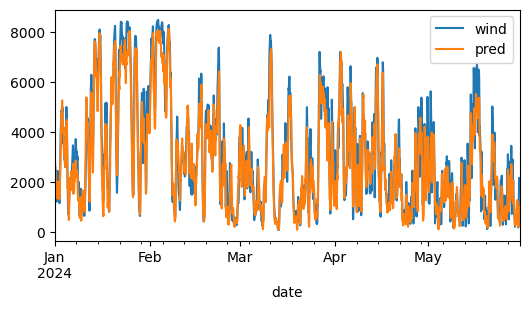

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['wind'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

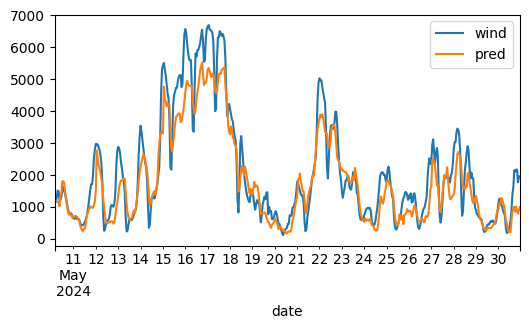

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['wind'][-500:].plot(ax=ax)
predictions[-500:].plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(
    df_train['wind'],
    exog = df_train[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                     'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                     'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']])
forecaster.get_feature_importances()

,feature,importance
0,lag_1,4201
15,wind_gusts_10m_wind3,3258
7,wind_speed_100m_wind2,2815
12,wind_speed_100m_wind3,2785
2,wind_speed_100m_wind1,2176
11,wind_speed_10m_wind3,2162
6,wind_speed_10m_wind2,2147
10,wind_gusts_10m_wind2,2101
13,wind_direction_10m_wind3,2086
9,wind_direction_100m_wind2,2011


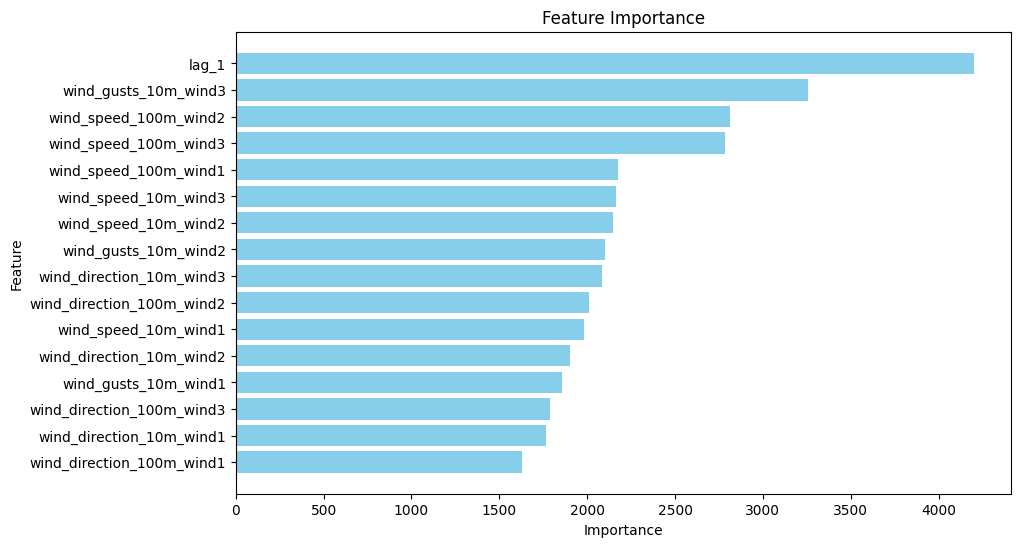

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

## 5.Total Generation Model

<Axes: >

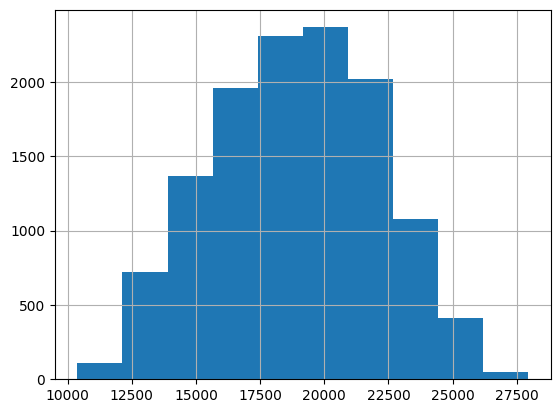

In [ ]:
df_model['total'].hist()

### 5.1. Recursive multi-step forecasting (without weather inputs)

#### 5.1.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 5899209.455210276
RMSE: 2428.828823777064
MAE: 1851.414012092189
MAPE: 0.0964713680154141
Custom MAPE: 0.0964713680154141
Custom sMAPE: 0.04904649690339731


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


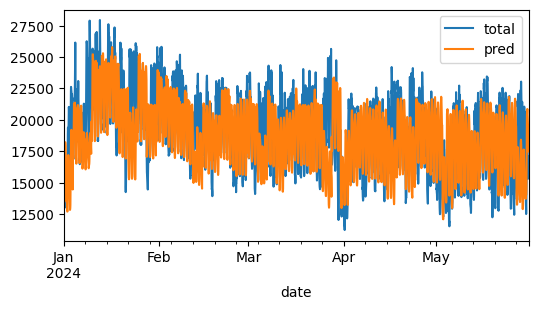

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(df_train['total'])
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.936143
22,lag_23,0.010582
21,lag_22,0.007727
1,lag_2,0.006191
5,lag_6,0.004017
2,lag_3,0.003465
12,lag_13,0.003383
20,lag_21,0.003209
11,lag_12,0.003010
13,lag_14,0.002101


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


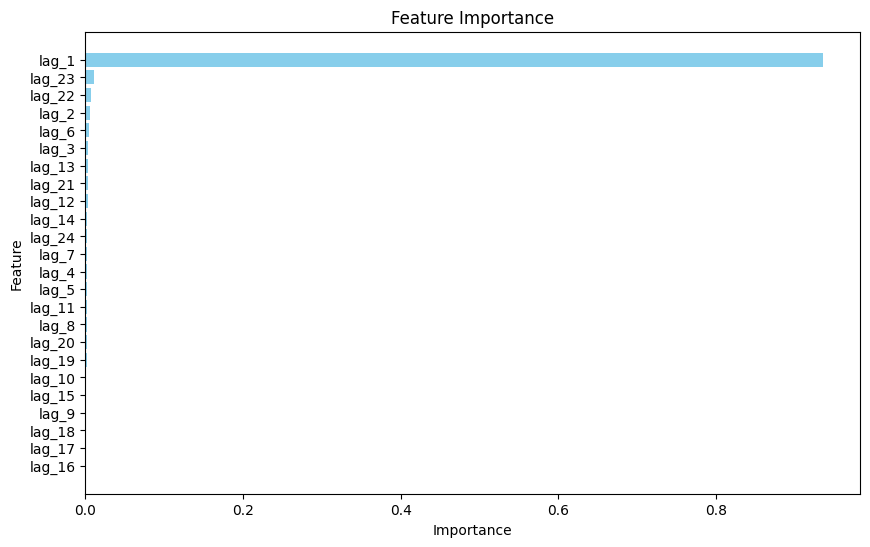

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.1.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 24
[LightGBM] [Info] Start training from score 18756.720898


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 6867554.595580223
RMSE: 2620.601952907046
MAE: 2018.1430714918624
MAPE: 0.10470846106958917
Custom MAPE: 0.10470846106958917
Custom sMAPE: 0.05366764954991572


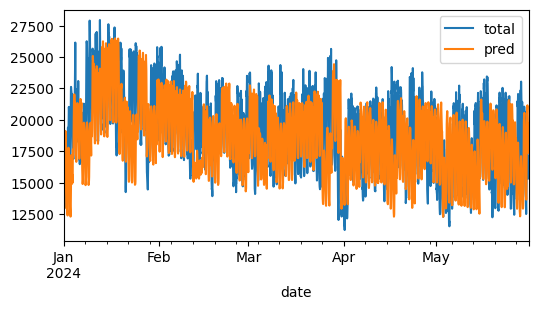

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(df_train['total'])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 24
[LightGBM] [Info] Start training from score 18756.720898


,feature,importance
0,lag_1,515
1,lag_2,219
22,lag_23,195
23,lag_24,180
13,lag_14,127
10,lag_11,125
21,lag_22,120
12,lag_13,117
18,lag_19,112
5,lag_6,108


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


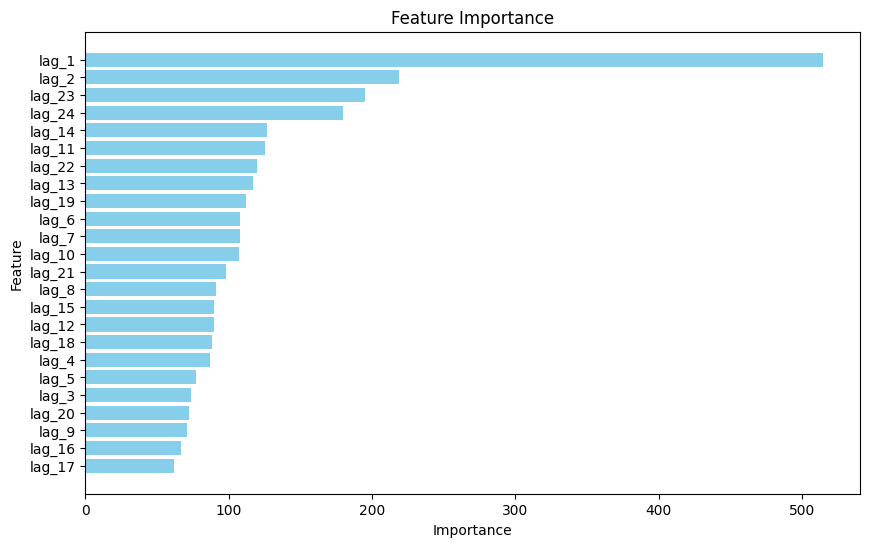

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.1.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 6188953.719837234
RMSE: 2487.760784287194
MAE: 1859.587271781414
MAPE: 0.09701824313280981
Custom MAPE: 0.09701824313280981
Custom sMAPE: 0.04913644898478971


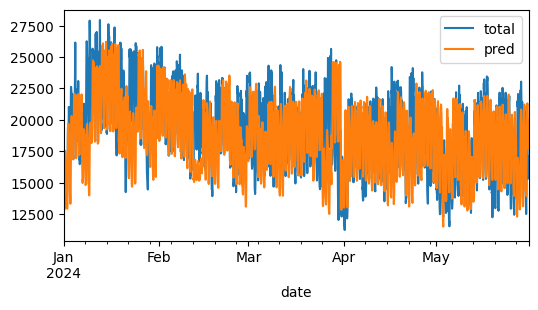

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(df_train['total'])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,feature,importance
0,lag_1,0.832215
22,lag_23,0.018903
21,lag_22,0.018414
1,lag_2,0.014781
20,lag_21,0.013591
5,lag_6,0.011949
12,lag_13,0.008963
19,lag_20,0.008797
10,lag_11,0.007332
13,lag_14,0.006862


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


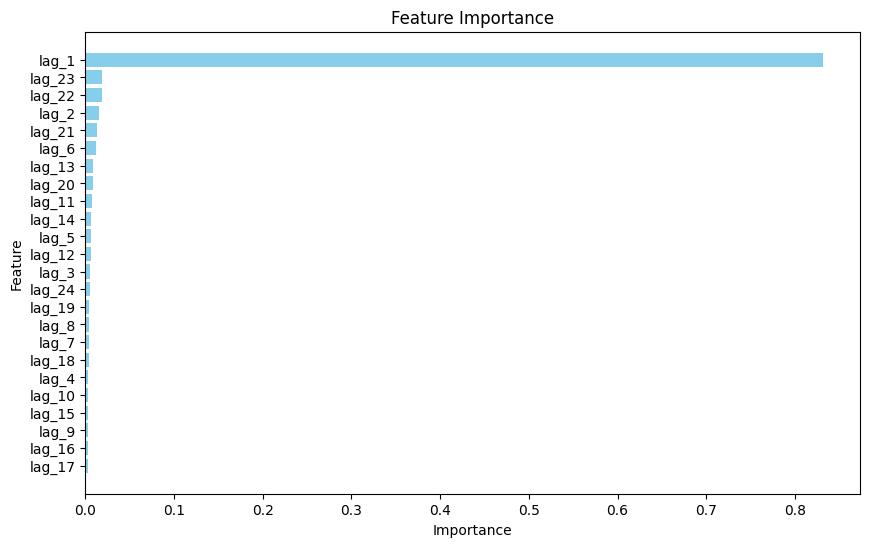

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

### 5.2. Recursive multi-step forecasting (with temp, dow, month, hour)

#### 5.2.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 2862561.1921947342
RMSE: 1691.9105154217625
MAE: 1273.8826474799894
MAPE: 0.06701629715094802
Custom MAPE: 0.06701629715094802
Custom sMAPE: 0.03334829172142293


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


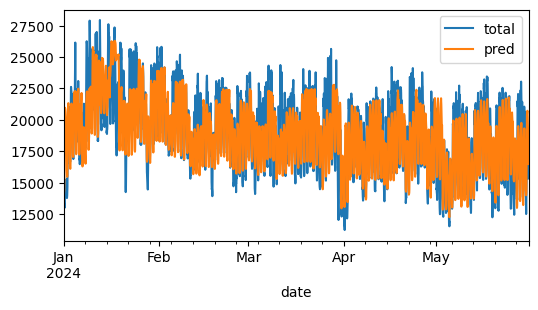

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(
    df_train['total'],
    exog = df_train[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,feature,importance
0,lag_1,0.935730
29,hhour,0.016507
22,lag_23,0.008083
21,lag_22,0.005822
1,lag_2,0.004361
2,lag_3,0.002925
27,dow,0.002552
5,lag_6,0.002079
20,lag_21,0.001680
3,lag_4,0.001579


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


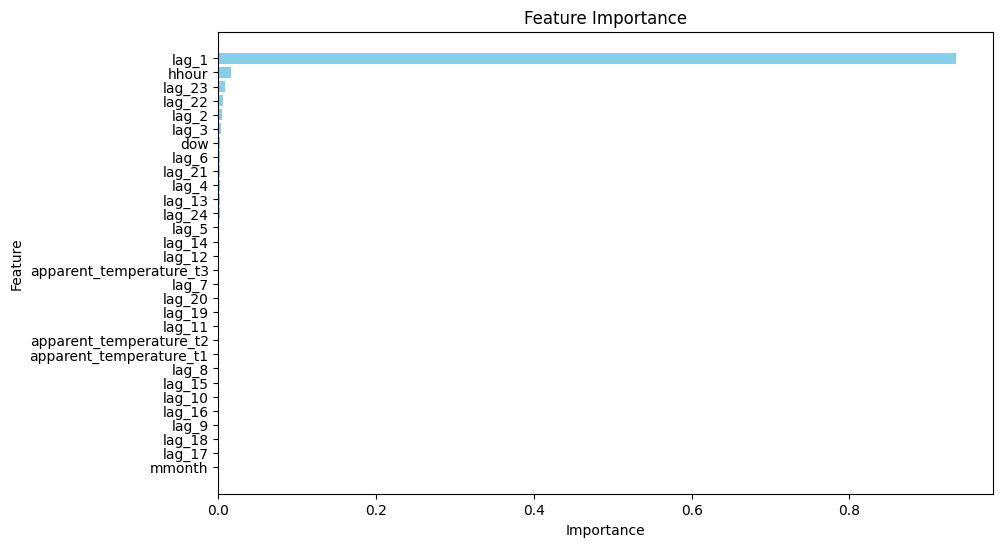

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.2.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6929
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 30
[LightGBM] [Info] Start training from score 18756.720898


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 2082780.0364187357
RMSE: 1443.1839925729275
MAE: 1058.9090437208772
MAPE: 0.05616105098581873
Custom MAPE: 0.05616105098581873
Custom sMAPE: 0.02782607656713799


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


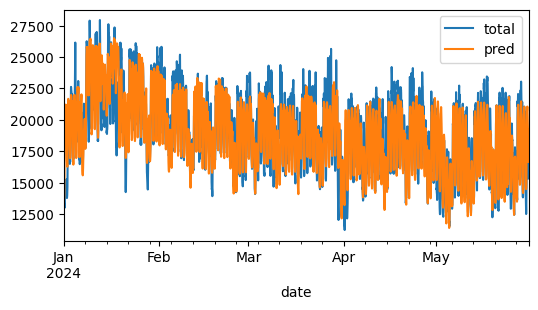

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(
    df_train['total'],
    exog = df_train[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6929
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 30
[LightGBM] [Info] Start training from score 18756.720898


,feature,importance
29,hhour,475
0,lag_1,382
22,lag_23,163
27,dow,149
1,lag_2,146
25,apparent_temperature_t2,133
24,apparent_temperature_t1,96
26,apparent_temperature_t3,84
12,lag_13,82
28,mmonth,78


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


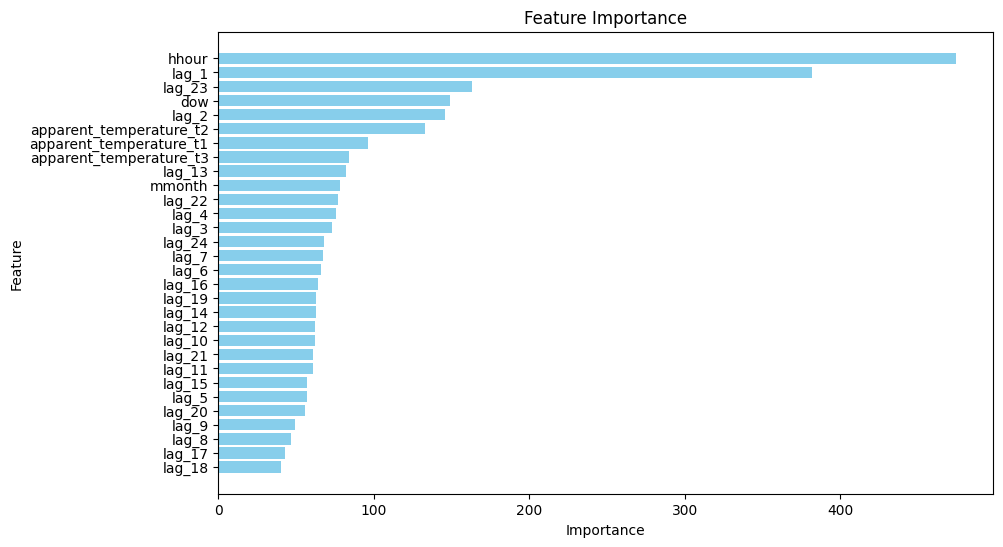

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.2.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 2135941.5333432895
RMSE: 1461.486070184485
MAE: 1082.729427895563
MAPE: 0.05776858103116737
Custom MAPE: 0.05776858103116737
Custom sMAPE: 0.028629577991020092


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


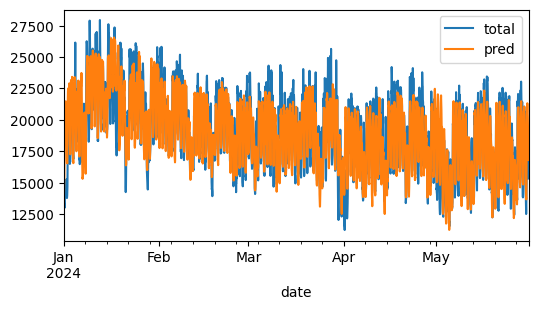

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(
    df_train['total'],
    exog = df_train[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,feature,importance
0,lag_1,0.821763
29,hhour,0.040776
22,lag_23,0.022623
21,lag_22,0.020434
27,dow,0.013640
5,lag_6,0.010273
1,lag_2,0.009378
19,lag_20,0.006234
12,lag_13,0.004877
13,lag_14,0.004694


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


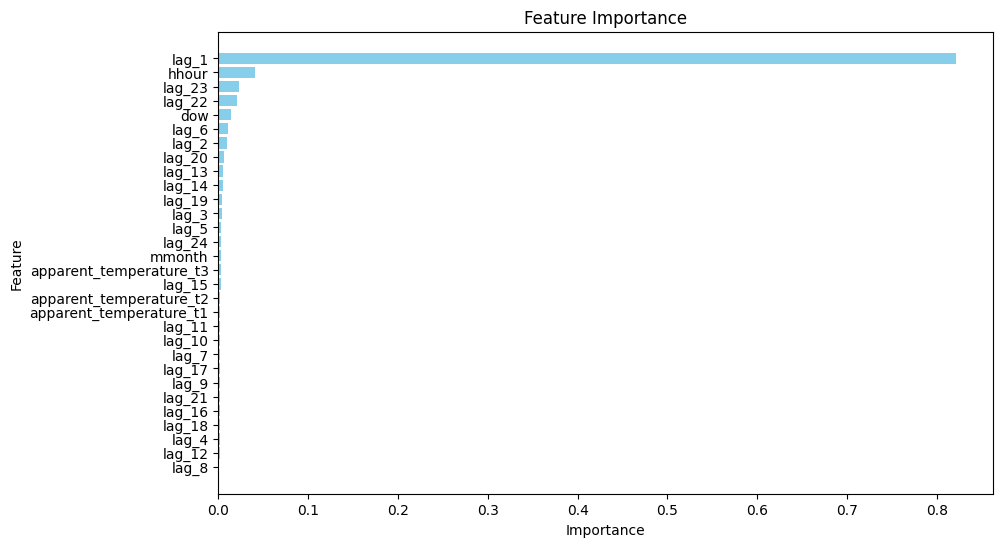

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 5.2.4. Optuna (LightGBM)

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1),
                 lags      = 24 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24]),
        'num_leaves'       : trial.suggest_int('num_leaves', 2, 256),
        'max_depth'        : trial.suggest_int('max_depth', -1, 16),
        'learning_rate'    : trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'n_estimators'     : trial.suggest_int('n_estimators', 50, 1500),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
        'subsample'        : trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq'   : trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          search_space          = search_space,
                          steps                 = 24*3,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          n_trials              = 100,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_total_recursive_optuna_lightGBM.txt"
                      )

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-19 08:58:31,412] Trial 0 finished with value: 1016.536892875592 and parameters: {'lags': 24, 'num_leaves': 109, 'max_depth': 16, 'learning_rate': 0.05486797781181634, 'n_estimators': 747, 'min_child_samples': 42, 'min_child_weight': 0.051986440302397775, 'subsample': 0.7561447366456374, 'subsample_freq': 4, 'colsample_bytree': 0.15371010694861154, 'reg_alpha': 1.528811858152725e-05, 'reg_lambda': 0.008016102206099943}. Best is trial 0 with value: 1016.536892875592.
[I 2024-07-19 08:58:41,263] Trial 1 finished with value: 1087.947183247644 and parameters: {'lags': 24, 'num_leaves': 218, 'max_depth': 12, 'learning_rate': 0.02780315255778501, 'n_estimators': 1098, 'min_child_samples': 36, 'min_child_weight': 0.06440851380101245, 'subsample': 0.30543690779106003, 'subsample_freq': 3, 'colsample_bytree': 0.667878511469039, 'reg_alpha': 5.455562299744123e-08, 'reg_lambda': 2.9485560066017848e-05}. Best is trial 0 with value: 1016.536892875592.
[I 2024-07-19 08:58:49,688] Trial 2 f

In [ ]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 24, 'num_leaves': 235, 'max_depth': 8, 'learning_rate': 0.009526427019740687, 'n_estimators': 579, 'min_child_samples': 22, 'min_child_weight': 1.880473319475264, 'subsample': 0.42862974888072636, 'subsample_freq': 2, 'colsample_bytree': 0.42583359368120627, 'reg_alpha': 5.763982197154911e-07, 'reg_lambda': 4.198630188495743e-08}
977.1635085723782


In [ ]:
params = { 'num_leaves': 235, 'max_depth': 8, 'learning_rate': 0.009526427019740687, 'n_estimators': 579, 'min_child_samples': 22,
          'min_child_weight': 1.880473319475264, 'subsample': 0.42862974888072636, 'subsample_freq': 2, 'colsample_bytree': 0.42583359368120627,
           'reg_alpha': 5.763982197154911e-07, 'reg_lambda': 4.198630188495743e-08}

# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1779949.7272608394
RMSE: 1334.1475657740561
MAE: 977.1635085723782
MAPE: 0.05253830208960649
Custom MAPE: 0.05253830208960649
Custom sMAPE: 0.025771575555989037


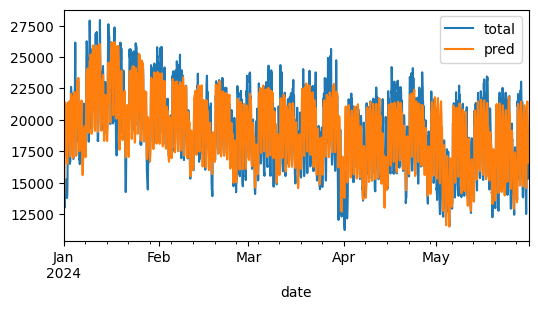

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['total'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show();

In [ ]:
forecaster.fit(
    df_train['total'],
    exog = df_train[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']])
forecaster.get_feature_importances()

,feature,importance
0,lag_1,5405
1,lag_2,3567
29,hhour,2927
2,lag_3,2820
23,lag_24,1813
3,lag_4,1721
22,lag_23,1656
25,apparent_temperature_t2,1626
24,apparent_temperature_t1,1478
26,apparent_temperature_t3,1475


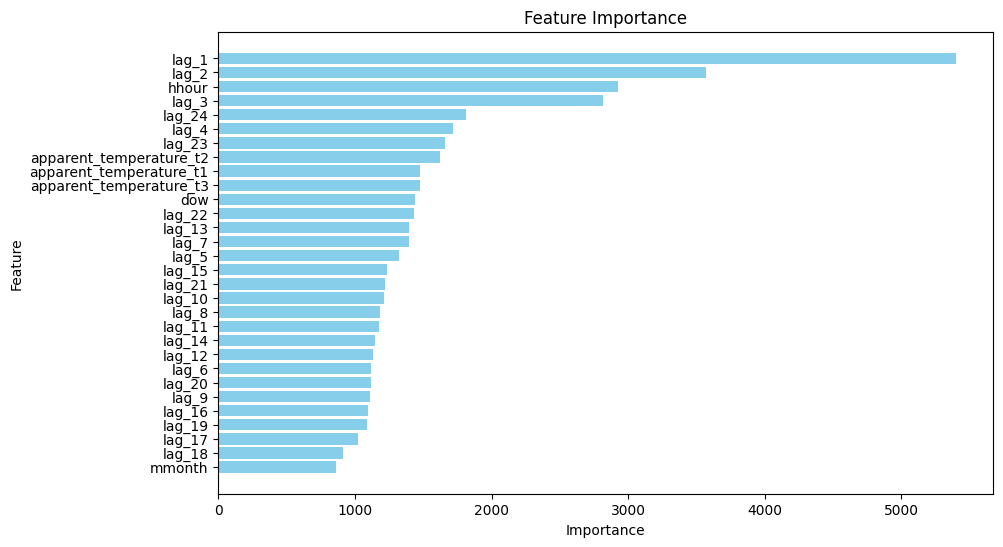

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

## 6.PV Generation Model

<Axes: >

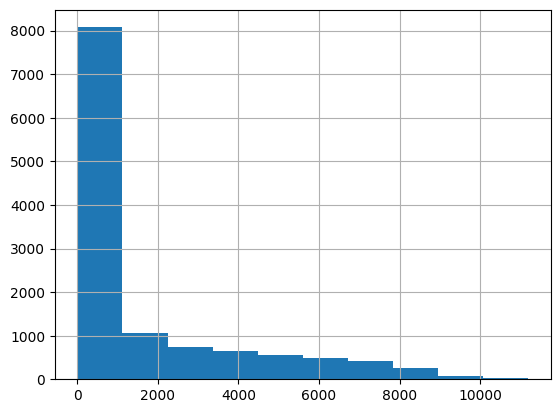

In [ ]:
df_model['pv'].hist()

### 6.1. Recursive multi-step forecasting (without weather inputs)

#### 6.1.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1119631.1819801447
RMSE: 1058.126259942614
MAE: 518.3521856417334
MAPE: 424133611415446.3
Custom MAPE: 0.30510665538956055
Custom sMAPE: 0.13841123738684305


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


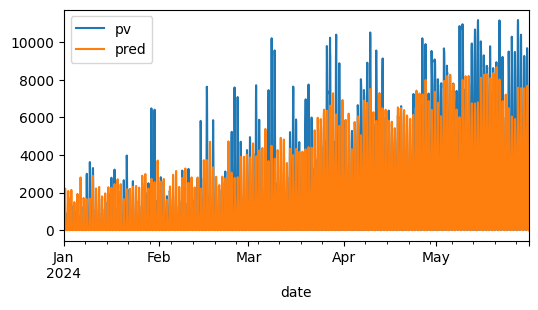

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


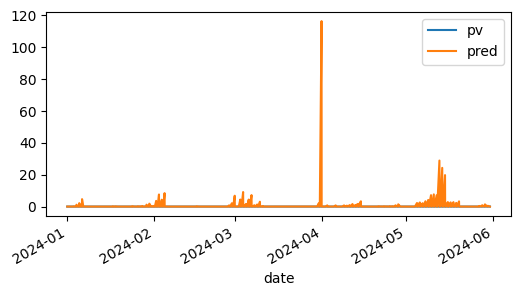

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

#### 6.1.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 24
[LightGBM] [Info] Start training from score 1512.660084


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1972138.6910224685
RMSE: 1404.3285552257594
MAE: 668.4481924240933
MAPE: 3031235980174534.5
Custom MAPE: 0.7720496244535756
Custom sMAPE: 0.5641394511230603


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


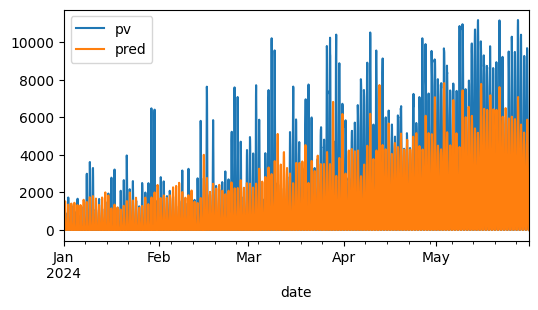

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


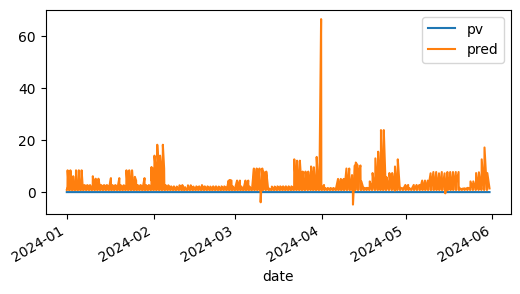

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

#### 6.1.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1851209.8115685363
RMSE: 1360.5917137659396
MAE: 651.9411104961247
MAPE: 1.2321331872157874e+16
Custom MAPE: 1.2973530002623355
Custom sMAPE: 0.5700898026132183


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


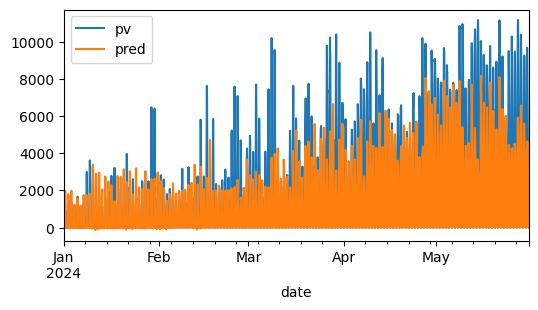

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


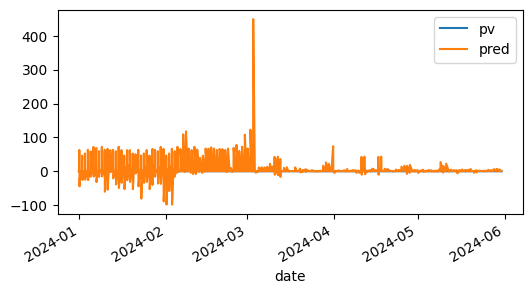

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

### 6.2. Recursive multi-step forecasting (with temp, month, hour)

#### 6.2.1. Random Forests

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 785777.2002716006
RMSE: 886.4407483140657
MAE: 423.4642491388352
MAPE: 391103530552452.4
Custom MAPE: 0.17661226108927558
Custom sMAPE: 0.10741965053289193


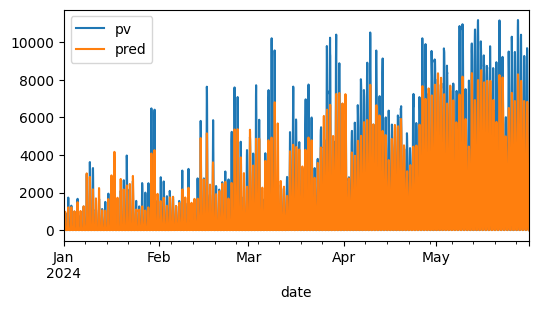

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

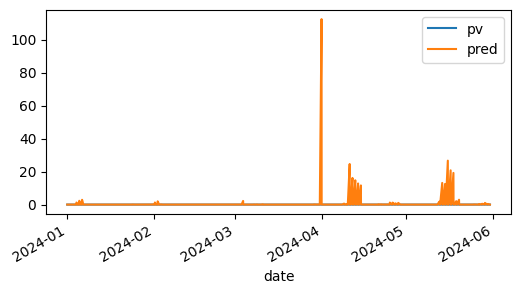

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
forecaster.fit(
    df_train['pv'],
    exog = df_train[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


,feature,importance
0,lag_1,0.508953
34,shortwave_radiation_t1,0.280050
28,terrestrial_radiation_t2,0.068360
38,terrestrial_radiation_t1,0.065445
48,terrestrial_radiation_t3,0.019559
20,lag_21,0.008611
19,lag_20,0.007794
23,lag_24,0.005757
18,lag_19,0.005281
21,lag_22,0.003287


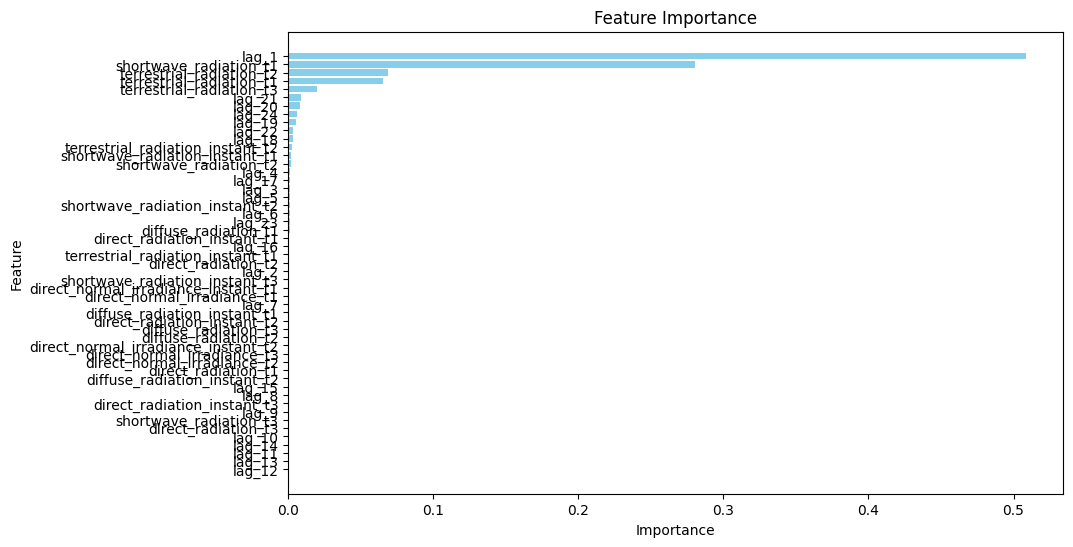

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 6.2.2. LightGBM

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 51
[LightGBM] [Info] Start training from score 1512.660084


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 849748.824645367
RMSE: 921.8182167029283
MAE: 450.04231134841206
MAPE: 3619882115886306.5
Custom MAPE: 0.6468489727889378
Custom sMAPE: 0.5517050245984256


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


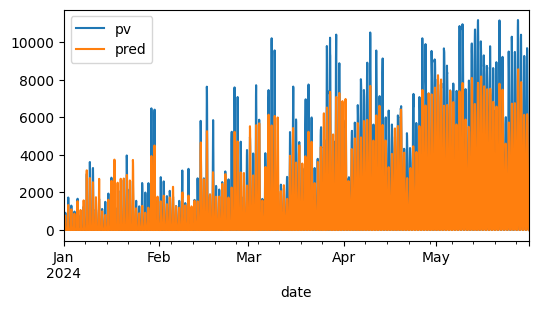

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


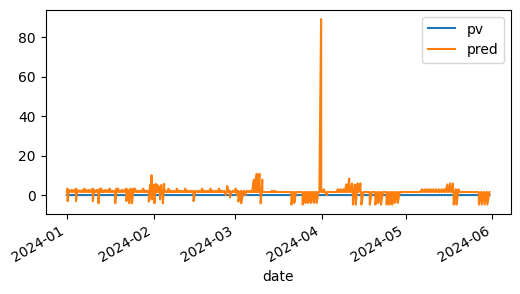

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
forecaster.fit(
    df_train['pv'],
    exog = df_train[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 8735, number of used features: 51
[LightGBM] [Info] Start training from score 1512.660084


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


,feature,importance
0,lag_1,615
2,lag_3,133
23,lag_24,127
46,diffuse_radiation_t3,101
1,lag_2,99
3,lag_4,90
26,diffuse_radiation_t2,86
34,shortwave_radiation_t1,86
36,diffuse_radiation_t1,73
24,shortwave_radiation_t2,73


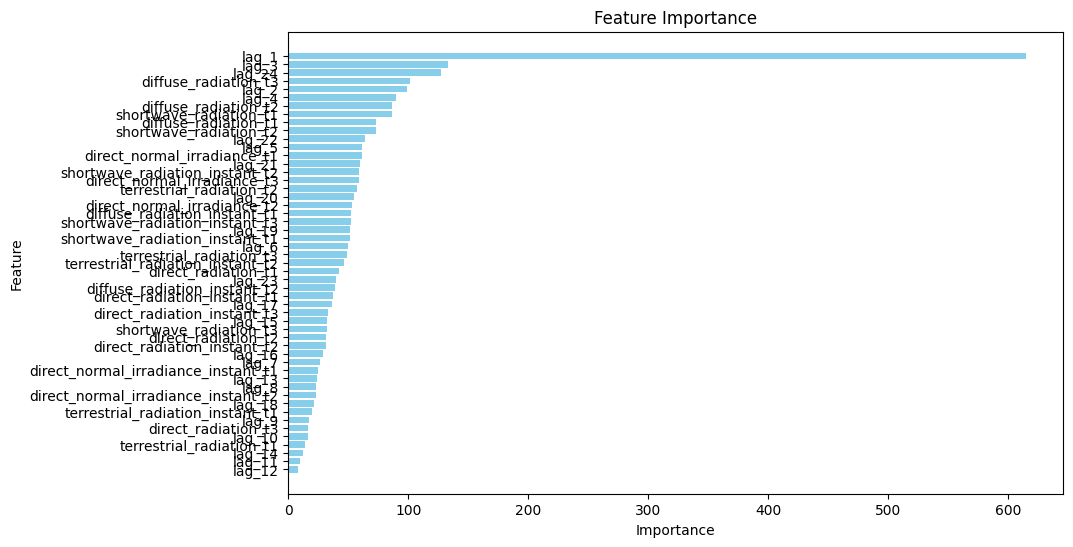

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 6.2.3. XGBoost

In [ ]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 975383.8483551132
RMSE: 987.6152329501167
MAE: 479.6762895988257
MAPE: 1410078321842227.5
Custom MAPE: 0.6243743747381307
Custom sMAPE: 0.534577863048366


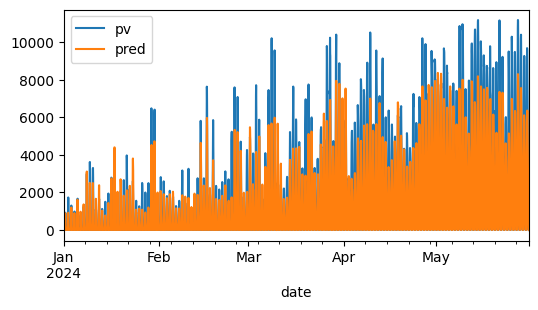

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


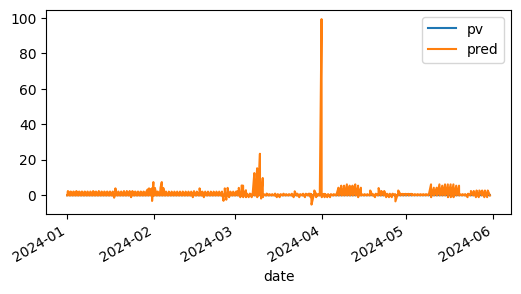

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

#### 6.2.4. Optuna (LightGBM)

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1),
                 lags      = 24 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24]),
        'num_leaves'       : trial.suggest_int('num_leaves', 2, 256),
        'max_depth'        : trial.suggest_int('max_depth', -1, 16),
        'learning_rate'    : trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
        'n_estimators'     : trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight' : trial.suggest_float('min_child_weight', 1e-3, 1e2, log=True),
        'subsample'        : trial.suggest_float('subsample', 0.1, 1.0),
        'subsample_freq'   : trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          search_space          = search_space,
                          steps                 = 24*3,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          n_trials              = 100,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_pv_recursive_optuna_lightGBM.txt"
                      )

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-07-19 09:15:48,590] Trial 0 finished with value: 406.44710401740684 and parameters: {'lags': 24, 'num_leaves': 109, 'max_depth': 16, 'learning_rate': 0.05486797781181634, 'n_estimators': 507, 'min_child_samples': 42, 'min_child_weight': 0.051986440302397775, 'subsample': 0.7561447366456374, 'subsample_freq': 4, 'colsample_bytree': 0.15371010694861154, 'reg_alpha': 1.528811858152725e-05, 'reg_lambda': 0.008016102206099943}. Best is trial 0 with value: 406.44710401740684.
[I 2024-07-19 09:15:56,280] Trial 1 finished with value: 434.08061531775473 and parameters: {'lags': 24, 'num_leaves': 218, 'max_depth': 12, 'learning_rate': 0.02780315255778501, 'n_estimators': 737, 'min_child_samples': 36, 'min_child_weight': 0.06440851380101245, 'subsample': 0.30543690779106003, 'subsample_freq': 3, 'colsample_bytree': 0.667878511469039, 'reg_alpha': 5.455562299744123e-08, 'reg_lambda': 2.9485560066017848e-05}. Best is trial 0 with value: 406.44710401740684.
[I 2024-07-19 09:16:02,254] Trial 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [ ]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 3, 'num_leaves': 101, 'max_depth': 6, 'learning_rate': 0.017529735620051917, 'n_estimators': 508, 'min_child_samples': 7, 'min_child_weight': 0.010296408018995049, 'subsample': 0.809574146025947, 'subsample_freq': 6, 'colsample_bytree': 0.14977481474881826, 'reg_alpha': 0.00030341478940107565, 'reg_lambda': 0.44301812573234994}
394.4094154635002


In [ ]:
params = {'num_leaves': 101, 'max_depth': 6, 'learning_rate': 0.017529735620051917, 'n_estimators': 508, 'min_child_samples': 7,
          'min_child_weight': 0.010296408018995049, 'subsample': 0.809574146025947, 'subsample_freq': 6, 'colsample_bytree': 0.14977481474881826,
          'reg_alpha': 0.00030341478940107565, 'reg_lambda': 0.44301812573234994}


# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 3
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 661259.0620011785
RMSE: 813.1783703476
MAE: 394.4094154635002
MAPE: 3039461503546237.0
Custom MAPE: 0.5899064752084968
Custom sMAPE: 0.5238387559382538


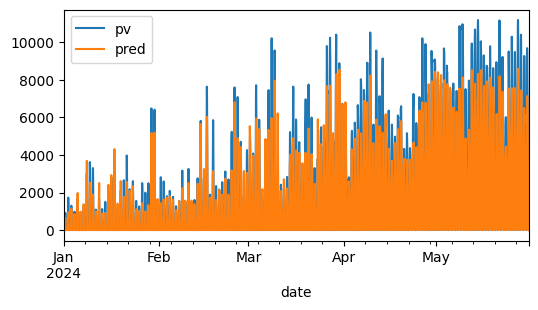

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

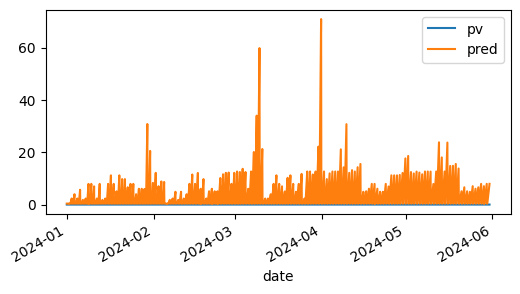

In [ ]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

In [ ]:
def correct_pv_predictions(pred_pv, shortwave_radiation):
  return 0 if shortwave_radiation == 0 or pred_pv < 0 else pred_pv

In [ ]:
predictions_pv_corrected = \
pd.DataFrame({'predictions_pv': predictions.pred, 'shortwave_radiation_t1': df_test.shortwave_radiation_t1})

predictions_pv_corrected['predictions_pv'] = \
predictions_pv_corrected.apply(lambda row: correct_pv_predictions(row.predictions_pv, row.shortwave_radiation_t1), axis = 1)

predictions_pv_corrected = predictions_pv_corrected['predictions_pv']
predictions_pv_corrected

2024-01-01 00:00:00+01:00       0.000000
2024-01-01 01:00:00+01:00       0.000000
2024-01-01 02:00:00+01:00       0.000000
2024-01-01 03:00:00+01:00       0.000000
2024-01-01 04:00:00+01:00       0.000000
                                ...     
2024-05-30 19:00:00+02:00    2096.885721
2024-05-30 20:00:00+02:00     846.560296
2024-05-30 21:00:00+02:00     236.642110
2024-05-30 22:00:00+02:00       0.000000
2024-05-30 23:00:00+02:00       0.000000
Freq: H, Name: predictions_pv, Length: 3623, dtype: float64

In [ ]:
# Backtest error
# ==============================================================================
print("MSE: " + str(mean_squared_error(df_test.pv, predictions_pv_corrected)))
print("RMSE: " + str(mean_squared_error(df_test.pv, predictions_pv_corrected)**0.5))
print("MAE: " +  str(mean_absolute_error(df_test.pv, predictions_pv_corrected)))
print("Custom MAPE: " +  str(custom_mape(df_test.pv, predictions_pv_corrected)))
print("Custom sMAPE: " +  str(custom_smape(df_test.pv, predictions_pv_corrected)))

MSE: 661321.4300620585
RMSE: 813.2167177708894
MAE: 394.45437146930846
Custom MAPE: 0.17713722196383486
Custom sMAPE: 0.1200064269163496


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
forecaster.fit(
    df_train['pv'],
    exog = df_train[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


,feature,importance
2,lag_3,1612
10,diffuse_radiation_instant_t2,1478
22,terrestrial_radiation_instant_t1,1429
14,direct_radiation_t1,1319
26,direct_normal_irradiance_t3,1302
18,shortwave_radiation_instant_t1,1287
0,lag_1,1257
6,direct_normal_irradiance_t2,1159
16,direct_normal_irradiance_t1,828
12,terrestrial_radiation_instant_t2,782


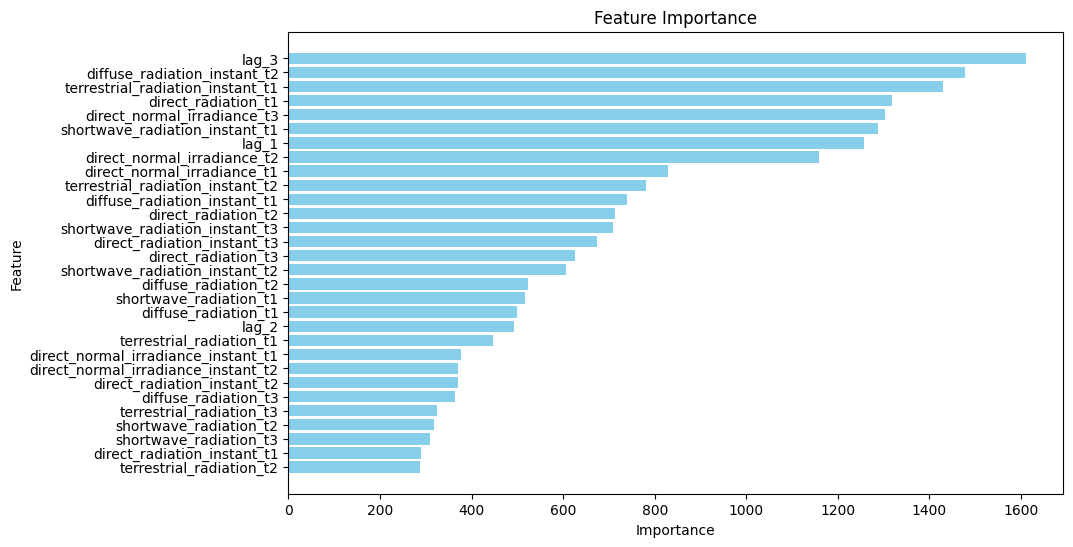

In [ ]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

#### 6.2.5. Optuna (Random Forests)

In [15]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 24 # Placeholder, the value will be overwritten
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'             : trial.suggest_categorical('lags', [1, 3, 6, 12, 24]),
        'n_estimators'     : trial.suggest_int('n_estimators', 100, 1000),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 20),
        "max_depth"        : trial.suggest_int("max_depth", 2, 15),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 50),
        'max_features'     : trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'max_samples'      : trial.suggest_float('max_samples', 0.1, 1.0, step=0.1)
    }

    return search_space

results, best_trial = bayesian_search_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          search_space          = search_space,
                          steps                 = 24*3,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error'],
                          refit                 = False,
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          n_trials              = 50,
                          random_state          = 123,
                          return_best           = True,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {},
                          output_file           = google_drive_path + "results_pv_recursive_optuna_lightGBM.txt"
                      )

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-07-22 06:56:03,796] Trial 0 finished with value: 388.66779380274767 and parameters: {'lags': 24, 'n_estimators': 481, 'min_samples_leaf': 20, 'max_depth': 11, 'min_samples_split': 25, 'max_features': 'sqrt', 'max_samples': 0.8}. Best is trial 0 with value: 388.66779380274767.
[I 2024-07-22 06:56:47,932] Trial 1 finished with value: 396.56949339872097 and parameters: {'lags': 12, 'n_estimators': 258, 'min_samples_leaf': 11, 'max_depth': 9, 'min_samples_split': 33, 'max_features': 'sqrt', 'max_samples': 0.7000000000000001}. Best is trial 0 with value: 388.66779380274767.
[I 2024-07-22 06:58:33,806] Trial 2 finished with value: 392.62221620668157 and parameters: {'lags': 1, 'n_estimators': 668, 'min_samples_leaf': 2, 'max_depth': 8, 'min_samples_split': 23, 'max_features': 'sqrt', 'max_samples': 0.4}. Best is trial 0 with value: 388.66779380274767.
[I 2024-07-22 06:59:07,708] Trial 3 finished with value: 393.3178060431346 and parameters: {'lags': 6, 'n_estimators': 204, 'min_sampl

In [18]:
# Print the best hyperparameters
print(best_trial.params)
print(best_trial.value)

{'lags': 24, 'n_estimators': 272, 'min_samples_leaf': 6, 'max_depth': 13, 'min_samples_split': 44, 'max_features': 'log2', 'max_samples': 0.5}
387.17123612314856


In [38]:
params = {'n_estimators': 272, 'min_samples_leaf': 6, 'max_depth': 13, 'min_samples_split': 44, 'max_features': 'log2', 'max_samples': 0.5}

# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123, **params),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [39]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 677470.5681915986
RMSE: 823.086002913182
MAE: 387.17123612314856
MAPE: 921367078235417.5
Custom MAPE: 0.5855850039258641
Custom sMAPE: 0.5128466964213715


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


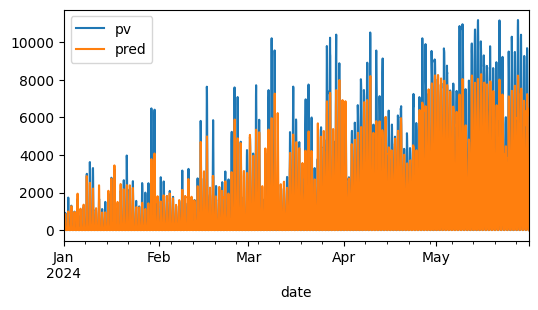

In [40]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test['pv'].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


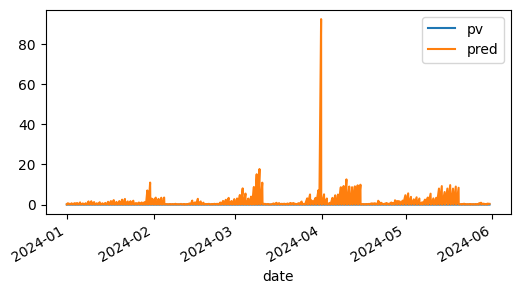

In [41]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
df_test[df_test.pv == 0]['pv'].plot(ax=ax)
predictions[df_test.pv == 0].plot(ax=ax)
ax.legend()
plt.show()

In [42]:
def correct_pv_predictions(pred_pv, shortwave_radiation):
  return 0 if shortwave_radiation == 0 or pred_pv < 0 else pred_pv

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
predictions_pv_corrected = \
pd.DataFrame({'predictions_pv': predictions.pred, 'shortwave_radiation_t1': df_test.shortwave_radiation_t1})

predictions_pv_corrected['predictions_pv'] = \
predictions_pv_corrected.apply(lambda row: correct_pv_predictions(row.predictions_pv, row.shortwave_radiation_t1), axis = 1)

predictions_pv_corrected = predictions_pv_corrected['predictions_pv']
predictions_pv_corrected

2024-01-01 00:00:00+01:00       0.000000
2024-01-01 01:00:00+01:00       0.000000
2024-01-01 02:00:00+01:00       0.000000
2024-01-01 03:00:00+01:00       0.000000
2024-01-01 04:00:00+01:00       0.000000
                                ...     
2024-05-30 19:00:00+02:00    2230.552411
2024-05-30 20:00:00+02:00     940.444754
2024-05-30 21:00:00+02:00     265.120966
2024-05-30 22:00:00+02:00       0.000000
2024-05-30 23:00:00+02:00       0.000000
Freq: H, Name: predictions_pv, Length: 3623, dtype: float64

In [44]:
# Backtest error
# ==============================================================================
print("MSE: " + str(mean_squared_error(df_test.pv, predictions_pv_corrected)))
print("RMSE: " + str(mean_squared_error(df_test.pv, predictions_pv_corrected)**0.5))
print("MAE: " +  str(mean_absolute_error(df_test.pv, predictions_pv_corrected)))
print("Custom MAPE: " +  str(custom_mape(df_test.pv, predictions_pv_corrected)))
print("Custom sMAPE: " +  str(custom_smape(df_test.pv, predictions_pv_corrected)))

MSE: 677549.3582218727
RMSE: 823.1338640961583
MAE: 387.84232300876226
Custom MAPE: 0.1718801642243637
Custom sMAPE: 0.11392762385978446


In [45]:
forecaster.fit(
    df_train['pv'],
    exog = df_train[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']])
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,feature,importance
28,terrestrial_radiation_t2,0.083352
0,lag_1,0.078516
48,terrestrial_radiation_t3,0.075052
34,shortwave_radiation_t1,0.065382
39,shortwave_radiation_instant_t1,0.064749
43,terrestrial_radiation_instant_t1,0.055504
23,lag_24,0.054452
33,terrestrial_radiation_instant_t2,0.052821
38,terrestrial_radiation_t1,0.045834
24,shortwave_radiation_t2,0.045523


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


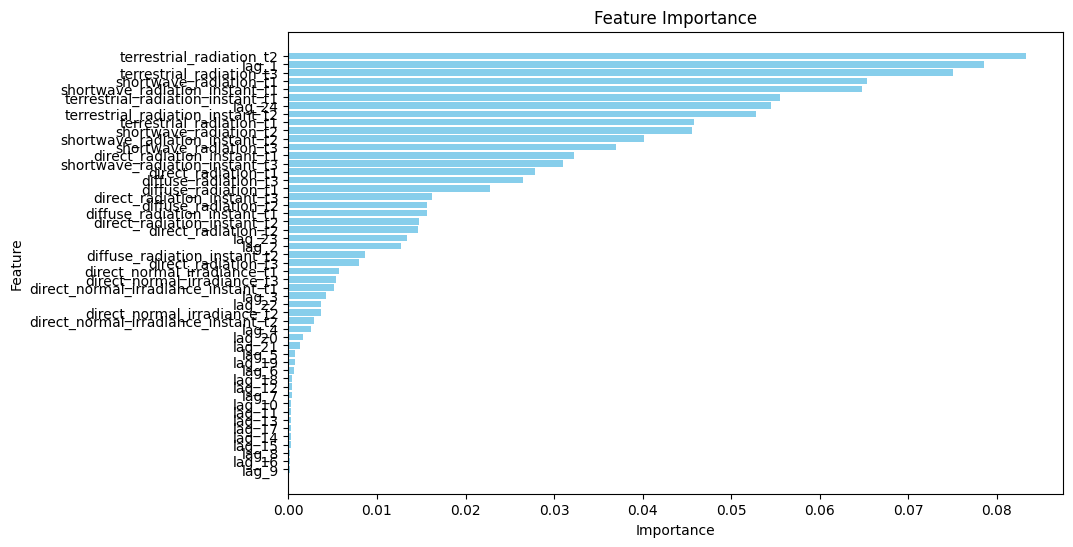

In [46]:
df = forecaster.get_feature_importances().sort_values(by='importance', ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['feature'], df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

## 7.Performance Evaluation

### 7.1. Best wind model

In [47]:
params = {'num_leaves': 112, 'max_depth': 6, 'learning_rate': 0.022526024805622016, 'n_estimators': 1493, 'min_child_samples': 84,
          'min_child_weight': 14.441115774305716, 'subsample': 0.9202436736620503, 'subsample_freq': 9, 'colsample_bytree': 0.3001501638643163,
          'reg_alpha': 3.4379043324716714e-08, 'reg_lambda': 0.013468881980138242}


# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 1
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['wind'],
                          exog                  = df_model[['wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1',
                                                            'wind_speed_10m_wind2', 'wind_speed_100m_wind2', 'wind_direction_10m_wind2', 'wind_direction_100m_wind2', 'wind_gusts_10m_wind2',
                                                            'wind_speed_10m_wind3', 'wind_speed_100m_wind3', 'wind_direction_10m_wind3', 'wind_direction_100m_wind3', 'wind_gusts_10m_wind3']],                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [48]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 384239.47990028595
RMSE: 619.8705347895526
MAE: 468.62116599147225
MAPE: 0.20878069620073958
Custom MAPE: 0.20878069620073958
Custom sMAPE: 0.10703653149422558


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
def correct_wind_predictions(pred_wind):
  pred_wind.pred = pred_wind.pred.apply(lambda x: 0 if x < 0 else x)
  return pred_wind.pred

In [51]:
predictions_wind_corrected = correct_wind_predictions(predictions)

In [52]:
# Backtest error
# ==============================================================================
print("MSE: " + str(mean_squared_error(df_test.wind, predictions_wind_corrected)))
print("RMSE: " + str(mean_squared_error(df_test.wind, predictions_wind_corrected)**0.5))
print("MAE: " +  str(mean_absolute_error(df_test.wind, predictions_wind_corrected)))
print("Custom MAPE: " +  str(custom_mape(df_test.wind, predictions_wind_corrected)))
print("Custom sMAPE: " +  str(custom_smape(df_test.wind, predictions_wind_corrected)))

MSE: 384239.47990028595
RMSE: 619.8705347895526
MAE: 468.62116599147225
Custom MAPE: 0.20878069620073958
Custom sMAPE: 0.10703653149422558


### 7.2. Best total model

In [53]:
params = { 'num_leaves': 235, 'max_depth': 8, 'learning_rate': 0.009526427019740687, 'n_estimators': 579, 'min_child_samples': 22,
          'min_child_weight': 1.880473319475264, 'subsample': 0.42862974888072636, 'subsample_freq': 2, 'colsample_bytree': 0.42583359368120627,
           'reg_alpha': 5.763982197154911e-07, 'reg_lambda': 4.198630188495743e-08}

# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose = -1, **params),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['total'],
                          exog                  = df_model[['apparent_temperature_t1', 'apparent_temperature_t2', 'apparent_temperature_t3', 'dow', 'mmonth', 'hhour']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [54]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 1779949.7272608394
RMSE: 1334.1475657740561
MAE: 977.1635085723782
MAPE: 0.05253830208960649
Custom MAPE: 0.05253830208960649
Custom sMAPE: 0.025771575555989037


### 7.3. Best PV model

In [55]:
params = {'n_estimators': 272, 'min_samples_leaf': 6, 'max_depth': 13, 'min_samples_split': 44, 'max_features': 'log2', 'max_samples': 0.5}

# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123, **params),
                 lags      = 24
             )

metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = df_model['pv'],
                          exog                  = df_model[['shortwave_radiation_t2', 'direct_radiation_t2', 'diffuse_radiation_t2', 'direct_normal_irradiance_t2',
                                                      'terrestrial_radiation_t2', 'shortwave_radiation_instant_t2', 'direct_radiation_instant_t2',
                                                      'diffuse_radiation_instant_t2', 'direct_normal_irradiance_instant_t2', 'terrestrial_radiation_instant_t2',
                                                      'shortwave_radiation_t1', 'direct_radiation_t1', 'diffuse_radiation_t1', 'direct_normal_irradiance_t1',
                                                      'terrestrial_radiation_t1', 'shortwave_radiation_instant_t1', 'direct_radiation_instant_t1',
                                                      'diffuse_radiation_instant_t1', 'direct_normal_irradiance_instant_t1', 'terrestrial_radiation_instant_t1',
                                                      'shortwave_radiation_t3', 'direct_radiation_t3', 'diffuse_radiation_t3', 'direct_normal_irradiance_t3',
                                                      'terrestrial_radiation_t3', 'shortwave_radiation_instant_t3', 'direct_radiation_instant_t3']],
                          steps                 = 24*3,
                          metric                = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', custom_mape, custom_smape],
                          initial_train_size    = len(df_train),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = False,
                          n_jobs                = 'auto',
                          verbose               = False,
                          show_progress         = True
                      )

  0%|          | 0/51 [00:00<?, ?it/s]

In [56]:
# Backtest error
# ==============================================================================
print("MSE: " + str(metric[0]))
print("RMSE: " + str(metric[0]**0.5))
print("MAE: " + str(metric[1]))
print("MAPE: " + str(metric[2]))
print("Custom MAPE: " + str(metric[3]))
print("Custom sMAPE: " + str(metric[4]))

MSE: 677470.5681915986
RMSE: 823.086002913182
MAE: 387.17123612314856
MAPE: 921367078235417.5
Custom MAPE: 0.5855850039258641
Custom sMAPE: 0.5128466964213715


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
def correct_pv_predictions(pred_pv, shortwave_radiation):
  return 0 if shortwave_radiation == 0 or pred_pv < 0 else pred_pv

In [59]:
predictions_pv_corrected = \
pd.DataFrame({'predictions_pv': predictions.pred, 'shortwave_radiation_t1': df_test.shortwave_radiation_t1})

predictions_pv_corrected['predictions_pv'] = \
predictions_pv_corrected.apply(lambda row: correct_pv_predictions(row.predictions_pv, row.shortwave_radiation_t1), axis = 1)

predictions_pv_corrected = predictions_pv_corrected['predictions_pv']
predictions_pv_corrected

2024-01-01 00:00:00+01:00       0.000000
2024-01-01 01:00:00+01:00       0.000000
2024-01-01 02:00:00+01:00       0.000000
2024-01-01 03:00:00+01:00       0.000000
2024-01-01 04:00:00+01:00       0.000000
                                ...     
2024-05-30 19:00:00+02:00    2230.552411
2024-05-30 20:00:00+02:00     940.444754
2024-05-30 21:00:00+02:00     265.120966
2024-05-30 22:00:00+02:00       0.000000
2024-05-30 23:00:00+02:00       0.000000
Freq: H, Name: predictions_pv, Length: 3623, dtype: float64

In [60]:
# Backtest error
# ==============================================================================
print("MSE: " + str(mean_squared_error(df_test.pv, predictions_pv_corrected)))
print("RMSE: " + str(mean_squared_error(df_test.pv, predictions_pv_corrected)**0.5))
print("MAE: " +  str(mean_absolute_error(df_test.pv, predictions_pv_corrected)))
print("Custom MAPE: " +  str(custom_mape(df_test.pv, predictions_pv_corrected)))
print("Custom sMAPE: " +  str(custom_smape(df_test.pv, predictions_pv_corrected)))

MSE: 677549.3582218727
RMSE: 823.1338640961583
MAE: 387.84232300876226
Custom MAPE: 0.1718801642243637
Custom sMAPE: 0.11392762385978446


# How to predict:
- Needs lags based on the lags the model was trained
- Needs exogenous parameters the same number as the steps ahead to be forecasted
- Both should be indexed based on datetimes

In [ ]:
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, num_leaves = 126, max_depth = 16, learning_rate = 0.006560371025154591,
                                           n_estimators = 877, min_child_samples = 95, min_child_weight = 0.006273241404256478, subsample = 0.6423580505833233,
                                           subsample_freq = 7, colsample_bytree = 0.2007842480609956, reg_alpha = 0.0003656058725013657,
                                           reg_lambda = 1.7710459138844433e-06, verbose = -1),
                 lags      = 2
             )

In [ ]:
forecaster.fit(df_train['pv'],
               exog = df_train[['apparent_temperature_pv1']])

In [ ]:
# Creating an hourly date range
hourly_date_range = pd.date_range(start='2024-06-30', periods=24, freq='H')

# Creating the Series
pv_series = pd.Series(
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    index=hourly_date_range,
    name='pv'
).tail(2)
pv_series

2024-06-30 22:00:00    23
2024-06-30 23:00:00    24
Freq: H, Name: pv, dtype: int64

In [ ]:
hourly_date_range = pd.date_range(start='2024-07-01', periods=3, freq='H')

df = pd.DataFrame({
    'apparent_temperature_pv1': [21, 22, 23]
}, index = hourly_date_range)
df

,apparent_temperature_pv1
2024-07-01 00:00:00,21
2024-07-01 01:00:00,22
2024-07-01 02:00:00,23


In [ ]:
forecaster.predict(steps = 3, exog = df.head(3), last_window = pv_series.tail(2) )

2024-07-01 00:00:00    57.901594
2024-07-01 01:00:00    70.404865
2024-07-01 02:00:00    80.551832
Freq: H, Name: pred, dtype: float64

## 4.1. Feature selection

In [ ]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import ShuffleSplit
from skforecast.datasets import fetch_dataset

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import select_features

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import select_features_multiseries

In [ ]:
# Create forecaster
# ==============================================================================
regressor = LGBMRegressor(
                n_estimators = 100,
                max_depth = 5,
                random_state = 15926,
                verbose = -1
            )

forecaster = ForecasterAutoreg(
                 regressor = regressor,
                 lags = 72
             )

# Recursive feature elimination with cross-validation
# ==============================================================================
selector = RFECV(
    estimator              = regressor,
    step                   = 1,
    cv                     = 5,
    min_features_to_select = 1,
    n_jobs                 = -1
)
selected_lags, selected_exog = select_features(
    forecaster      = forecaster,
    selector        = selector,
    y               = df_train['wind'],
    exog            = df_train.drop(columns = ['total', 'wind', 'oil',	'gas', 'coal', 'biomass', 'pv', 'water']),
    select_only     = None,
    force_inclusion = None,
    subsample       = 0.2,
    random_state    = 123,
    verbose         = True,
)

In [ ]:
# Feature selection (autoregressive and exog) with SelectFromModel + SequentialFeatureSelector
# ==============================================================================
regressor = LGBMRegressor(n_estimators=100, max_depth=5, random_state=15926, verbose=-1)

# Step 1: Select the 70% most important features with SelectFromModel
selector_1 = SelectFromModel(
                 estimator    = regressor,
                 max_features = int(df_train.shape[1] * 0.5),
                 threshold    = -np.inf
             )
selected_autoreg_1, selected_exog_1 = select_features(
    forecaster  = forecaster,
    selector    = selector_1,
    y           = df_train['wind'],
    exog        = df_train.drop(columns = ['total', 'wind', 'oil',	'gas', 'coal', 'biomass', 'pv', 'water']),
    select_only = None,
    subsample   = 0.2,
    verbose     = True,
)
print("")

# Step 2: Select the 25 most important features with SequentialFeatureSelector
forecaster.set_lags(lags=selected_autoreg_1)
selector_2 = SequentialFeatureSelector(
                 estimator            = regressor,
                #  n_features_to_select = 1,
                 direction            = "forward",
                 cv                   = ShuffleSplit(n_splits=1, test_size=0.3, random_state=951),
                 scoring              = "neg_mean_absolute_error",
                 n_jobs               = -1,
             )

# selector_2 = RFECV(
#     estimator              = regressor,
#     step                   = 1,
#     cv                     = 5,
#     min_features_to_select = 1,
#     n_jobs                 = -1
# )


selected_autoreg, selected_exog = select_features(
    forecaster  = forecaster,
    selector    = selector_2,
    y           = df_train['wind'],
    exog        = df_train[selected_exog_1],
    select_only = None,
    subsample   = 0.5,
    verbose     = True,
)

Recursive feature elimination (SelectFromModel)
-----------------------------------------------
Total number of records available: 8690
Total number of records used for feature selection: 1738
Number of features available: 306
    Autoreg (n=51)
    Exog    (n=255)
Number of features selected: 131
    Autoreg (n=51) : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 43, 45, 46, 47, 48, 52, 56, 57, 59, 61, 62, 63, 64, 65, 67, 68, 69, 71]
    Exog    (n=80) : ['relative_humidity_2m_wind1', 'apparent_temperature_wind1', 'pressure_msl_wind1', 'surface_pressure_wind1', 'cloud_cover_wind1', 'cloud_cover_mid_wind1', 'wind_speed_10m_wind1', 'wind_speed_100m_wind1', 'wind_direction_10m_wind1', 'wind_direction_100m_wind1', 'wind_gusts_10m_wind1', 'temperature_2m_wind2', 'relative_humidity_2m_wind2', 'apparent_temperature_wind2', 'precipitation_wind2', 'surface_pressure_wind2', 'cloud_cover_wind2', 'cloud_cover_low_wind2',